# 🎯 Xception: Deep Learning with Depthwise Separable Convolutions

## Bilgisayarlı Görü Dersi Sunumu

---

**📚 Makale:** Xception: Deep Learning with Depthwise Separable Convolutions  
**✍️ Yazar:** François Chollet (Google, Inc.)  
**📅 Yayın:** CVPR 2017  
**🔗 arXiv:** 1610.02357v3

---

**👨‍🎓 Sunan:**  
Çağatay ÜRESİN  
Öğrenci No: 20259257001  
Fen Bilimleri Enstitüsü - Bilgisayar Mühendisliği Anabilim Dalı  
📧 GitHub: [@cagatayuresin](https://github.com/cagatayuresin)  
📆 Sunum Tarihi: 17 Aralık 2025

---

### 📖 Bu Notebook'ta Neler Var?

1. **Teorik Altyapı:** Convolution türleri, Inception hipotezi
2. **İnteraktif Demolar:** Gerçek görüntü üzerinde convolution operasyonları
3. **Xception Mimarisi:** Detaylı mimari analizi
4. **Canlı Model:** Pre-trained Xception ile inference
5. **Deneysel Sonuçlar:** ImageNet ve JFT performans analizi
6. **Görselleştirmeler:** Grad-CAM, feature maps, interaktif grafikler

---

## 📦 Gerekli Kütüphanelerin Kurulumu

Bu hücreyi çalıştırarak tüm gerekli paketleri yükleyin.

In [26]:
%%capture
# Sessiz kurulum için %%capture kullanıyoruz

# Temel kütüphaneler
!pip install --upgrade pip
!pip install numpy matplotlib seaborn pillow

# Deep Learning
!pip install tensorflow>=2.13.0
!pip install torch torchvision

# Görselleştirme
!pip install plotly ipywidgets
!pip install opencv-python

# İnteraktif widget'lar için
#from google.colab import output
#output.enable_custom_widget_manager()

print("✅ Tüm kütüphaneler başarıyla yüklendi!")

In [27]:
# Kütüphaneleri import edelim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import seaborn as sns
from PIL import Image
import io
import requests
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception as XceptionModel
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

# PyTorch (alternatif kullanım için)
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# OpenCV
import cv2

# İnteraktif widget'lar
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Plotly offline mode
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

print("✅ Import işlemleri tamamlandı!")
print(f"🔧 TensorFlow version: {tf.__version__}")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🎨 Matplotlib backend: {plt.get_backend()}")

✅ Import işlemleri tamamlandı!
🔧 TensorFlow version: 2.19.0
🔧 PyTorch version: 2.9.0+cpu
🎨 Matplotlib backend: module://matplotlib_inline.backend_inline


---

# 🎬 BÖLÜM 1: Giriş ve Motivasyon

## 🤔 Neden Xception?

### Tarihsel Gelişim:

```
LeNet (1998)
    ↓
AlexNet (2012) → VGG (2014)
    ↓
GoogLeNet/Inception V1 (2014)
    ↓
Inception V2 & V3 (2015-2016)
    ↓
Xception (2017) ← "Extreme Inception"
```

### Ana Soru:

> **"Cross-channel correlations ve spatial correlations tamamen ayrılabilir mi?"**

### Xception'ın Hipotezi:

Inception modüllerini **depthwise separable convolutions** ile değiştirirsek:
- ✅ Daha verimli parametre kullanımı
- ✅ Daha iyi performans
- ✅ Aynı model boyutu

---

## 📊 Makale Sonuçları (Hızlı Bakış)

| Dataset | Metric | Inception V3 | Xception | İyileştirme |
|---------|--------|--------------|----------|-------------|
| **ImageNet** | Top-1 Accuracy | 78.2% | **79.0%** | +0.8% |
| **ImageNet** | Top-5 Accuracy | 94.1% | **94.5%** | +0.4% |
| **JFT** | MAP@100 | 6.50 | **6.78** | +4.3% |

**Parametre Sayısı:**
- Inception V3: 23.6M
- Xception: 22.9M (~%3 daha az!)

**Sonuç:** Daha az parametre ile daha iyi performans! 🎯

---

---

# 🧠 BÖLÜM 2: Teorik Altyapı

## 2.1 Regular Convolution Nedir?

### Matematiksel Tanım:

Input: $X \in \mathbb{R}^{H \times W \times C_{in}}$  
Kernel: $K \in \mathbb{R}^{k \times k \times C_{in} \times C_{out}}$  
Output: $Y \in \mathbb{R}^{H' \times W' \times C_{out}}$

Her output channel için:

$$Y[:,:,i] = \sum_{j=1}^{C_{in}} X[:,:,j] * K[:,:,j,i]$$

### Parametre Sayısı:

$$\text{Params}_{regular} = k \times k \times C_{in} \times C_{out}$$

### Hesaplama Maliyeti (FLOPS):

$$\text{FLOPS}_{regular} = H' \times W' \times k \times k \times C_{in} \times C_{out}$$

---

In [28]:
# Regular Convolution için yardımcı fonksiyonlar

def calculate_conv_params(kernel_size, in_channels, out_channels, conv_type='regular'):
    """
    Farklı convolution türleri için parametre sayısını hesapla

    Args:
        kernel_size: Kernel boyutu (k x k)
        in_channels: Input channel sayısı
        out_channels: Output channel sayısı
        conv_type: 'regular', 'depthwise', 'pointwise', 'separable'

    Returns:
        Parametre sayısı
    """
    k = kernel_size

    if conv_type == 'regular':
        return k * k * in_channels * out_channels

    elif conv_type == 'depthwise':
        # Her channel için ayrı k x k kernel
        return k * k * in_channels

    elif conv_type == 'pointwise':
        # 1x1 convolution
        return in_channels * out_channels

    elif conv_type == 'separable':
        # Depthwise + Pointwise
        depthwise = k * k * in_channels
        pointwise = in_channels * out_channels
        return depthwise + pointwise

    else:
        raise ValueError(f"Unknown conv_type: {conv_type}")


def calculate_flops(h_out, w_out, kernel_size, in_channels, out_channels, conv_type='regular'):
    """
    FLOPS hesaplama
    """
    k = kernel_size

    if conv_type == 'regular':
        return h_out * w_out * k * k * in_channels * out_channels

    elif conv_type == 'depthwise':
        return h_out * w_out * k * k * in_channels

    elif conv_type == 'pointwise':
        return h_out * w_out * in_channels * out_channels

    elif conv_type == 'separable':
        depthwise = h_out * w_out * k * k * in_channels
        pointwise = h_out * w_out * in_channels * out_channels
        return depthwise + pointwise

    else:
        raise ValueError(f"Unknown conv_type: {conv_type}")


def compression_ratio(kernel_size, in_channels, out_channels):
    """
    Depthwise Separable Conv'un Regular Conv'a göre sıkıştırma oranı
    """
    regular_params = calculate_conv_params(kernel_size, in_channels, out_channels, 'regular')
    separable_params = calculate_conv_params(kernel_size, in_channels, out_channels, 'separable')

    ratio = separable_params / regular_params
    reduction = (1 - ratio) * 100

    return ratio, reduction


print("✅ Yardımcı fonksiyonlar tanımlandı!")
print("\n📐 Örnek Hesaplama:")
print("="*50)

# Örnek değerler
k = 3
cin = 256
cout = 256

regular = calculate_conv_params(k, cin, cout, 'regular')
separable = calculate_conv_params(k, cin, cout, 'separable')
ratio, reduction = compression_ratio(k, cin, cout)

print(f"Kernel: {k}x{k}, Input Channels: {cin}, Output Channels: {cout}")
print(f"\n🔴 Regular Conv Parametreleri: {regular:,}")
print(f"🟢 Separable Conv Parametreleri: {separable:,}")
print(f"\n📉 Parametre Azalması: {reduction:.1f}%")
print(f"📊 Sıkıştırma Oranı: 1:{1/ratio:.1f}")

✅ Yardımcı fonksiyonlar tanımlandı!

📐 Örnek Hesaplama:
Kernel: 3x3, Input Channels: 256, Output Channels: 256

🔴 Regular Conv Parametreleri: 589,824
🟢 Separable Conv Parametreleri: 67,840

📉 Parametre Azalması: 88.5%
📊 Sıkıştırma Oranı: 1:8.7


## 📊 İnteraktif Parametre Hesaplayıcı

Slider'ları kullanarak farklı konfigürasyonlar için parametre sayısını karşılaştırın!

In [ ]:
def interactive_param_calculator(kernel_size, input_channels, output_channels):
    """
    İnteraktif parametre hesaplama ve görselleştirme
    """
    # Hesaplamalar
    regular = calculate_conv_params(kernel_size, input_channels, output_channels, 'regular')
    depthwise = calculate_conv_params(kernel_size, input_channels, output_channels, 'depthwise')
    pointwise = calculate_conv_params(kernel_size, input_channels, output_channels, 'pointwise')
    separable = calculate_conv_params(kernel_size, input_channels, output_channels, 'separable')

    ratio, reduction = compression_ratio(kernel_size, input_channels, output_channels)

    # FLOPS hesapla (output size 56x56 varsayalım)
    h_out, w_out = 56, 56
    flops_regular = calculate_flops(h_out, w_out, kernel_size, input_channels, output_channels, 'regular')
    flops_separable = calculate_flops(h_out, w_out, kernel_size, input_channels, output_channels, 'separable')

    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Sol grafik: Parametre sayıları
    ax1 = axes[0]
    conv_types = ['Regular\nConv', 'Depthwise\nConv', 'Pointwise\nConv', 'Separable\nConv\n(D+P)']
    param_counts = [regular, depthwise, pointwise, separable]
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

    bars = ax1.bar(conv_types, param_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Parametre Sayısı', fontsize=14, fontweight='bold')
    ax1.set_title(f'Parametre Karşılaştırması\n({kernel_size}x{kernel_size} kernel, {input_channels}→{output_channels} channels)',
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_yscale('log')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # Bar üzerine değerleri yaz
    for bar, count in zip(bars, param_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Sağ grafik: FLOPS karşılaştırması
    ax2 = axes[1]
    flops_types = ['Regular Conv', 'Separable Conv']
    flops_values = [flops_regular, flops_separable]
    colors2 = ['#e74c3c', '#f39c12']

    bars2 = ax2.bar(flops_types, flops_values, color=colors2, alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('FLOPS (Floating Point Operations)', fontsize=14, fontweight='bold')
    ax2.set_title(f'Hesaplama Maliyeti Karşılaştırması\n(Output: {h_out}x{w_out})',
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_yscale('log')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    # FLOPS bar üzerine değerleri yaz
    for bar, flops in zip(bars2, flops_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{flops/1e9:.2f}B',  # Milyarlık olarak göster
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Özet bilgiler
    print("\n" + "="*80)
    print("📊 ÖZET İSTATİSTİKLER")
    print("="*80)
    print(f"\n🔴 Regular Convolution:")
    print(f"   └─ Parametreler: {regular:,}")
    print(f"   └─ FLOPS: {flops_regular/1e9:.2f}B")
    print(f"\n🟠 Depthwise Separable Convolution:")
    print(f"   ├─ Depthwise: {depthwise:,} params")
    print(f"   ├─ Pointwise: {pointwise:,} params")
    print(f"   └─ Toplam: {separable:,} params")
    print(f"   └─ FLOPS: {flops_separable/1e9:.2f}B")
    print(f"\n💡 Kazanç:")
    print(f"   ├─ Parametre Azalması: {reduction:.1f}%")
    print(f"   ├─ Sıkıştırma Oranı: 1:{1/ratio:.1f}")
    print(f"   └─ FLOPS Azalması: {(1 - flops_separable/flops_regular)*100:.1f}%")
    print("="*80)


# İnteraktif widget
interact(interactive_param_calculator,
         kernel_size=widgets.IntSlider(min=3, max=7, step=2, value=3, description='Kernel Size:'),
         input_channels=widgets.IntSlider(min=32, max=512, step=32, value=256, description='Input Ch:'),
         output_channels=widgets.IntSlider(min=32, max=512, step=32, value=256, description='Output Ch:'));

## 2.2 Depthwise Separable Convolution

Depthwise Separable Convolution = **Depthwise Conv** + **Pointwise Conv**

### 🔹 Adım 1: Depthwise Convolution

Her input channel'a **ayrı ayrı** spatial convolution uygula:

$$Y_{depth}[:,:,i] = X[:,:,i] * K_{depth}[:,:,i]$$

**Parametreler:** $k \times k \times C_{in}$

### 🔹 Adım 2: Pointwise Convolution

1x1 convolution ile channel'ları mix et:

$$Y[:,:,j] = \sum_{i=1}^{C_{in}} Y_{depth}[:,:,i] \times K_{point}[1,1,i,j]$$

**Parametreler:** $C_{in} \times C_{out}$

### 🎯 Toplam Parametreler:

$$\text{Params}_{separable} = k \times k \times C_{in} + C_{in} \times C_{out}$$

### 📉 Parametre Azalma Oranı:

$$\frac{\text{Params}_{separable}}{\text{Params}_{regular}} = \frac{1}{C_{out}} + \frac{1}{k^2}$$

**Örnek:** $k=3, C_{out}=256$ için:
$$\frac{1}{256} + \frac{1}{9} \approx 0.115 \rightarrow \text{%88.5 azalma!}$$

---

---

# 🎨 BÖLÜM 3: Görsel Demo - Convolution Operasyonları

## 3.1 Test Görüntüsü Yükleme

Üç seçenek:
1. **Sample Image:** ImageNet'ten örnek görüntü indir
2. **Upload:** Kendi görüntünüzü yükleyin
3. **URL:** URL'den görüntü yükle

In [ ]:
def load_sample_image(image_choice='cat'):
    """
    Örnek görüntü yükle
    """
    # Unsplash'den yüksek kalite görüntüler
    image_urls = {
        'cat': 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=299&h=299&fit=crop',
        'dog': 'https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=299&h=299&fit=crop',
        'bird': 'https://images.unsplash.com/photo-1444464666168-49d633b86797?w=299&h=299&fit=crop',
        'flower': 'https://images.unsplash.com/photo-1490750967868-88aa4486c946?w=299&h=299&fit=crop',
        'car': 'https://images.unsplash.com/photo-1568605117036-5fe5e7bab0b7?w=299&h=299&fit=crop'
    }

    url = image_urls.get(image_choice, image_urls['cat'])

    try:
        response = requests.get(url, timeout=10)
        img = Image.open(io.BytesIO(response.content))
        img = img.convert('RGB')
        img = img.resize((299, 299), Image.Resampling.LANCZOS)
        return np.array(img)
    except Exception as e:
        print(f"❌ Görüntü yüklenemedi: {e}")
        # Fallback: random image
        return np.random.randint(0, 255, (299, 299, 3), dtype=np.uint8)


def upload_image():
    """
    Kullanıcıdan görüntü yükle
    """
    from google.colab import files

    print("📤 Lütfen bir görüntü yükleyin...")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        img = Image.open(io.BytesIO(uploaded[filename]))
        img = img.convert('RGB')
        img = img.resize((299, 299), Image.Resampling.LANCZOS)
        return np.array(img)
    else:
        print("❌ Görüntü yüklenemedi!")
        return None


# Demo için görüntü seçimi
print("🎨 Görüntü Seçimi")
print("="*50)
print("Lütfen aşağıdaki hücrelerden birini çalıştırın:")
print("\n1️⃣ Sample Image (önerilen)")
print("2️⃣ Upload Image")
print("3️⃣ URL'den yükle")

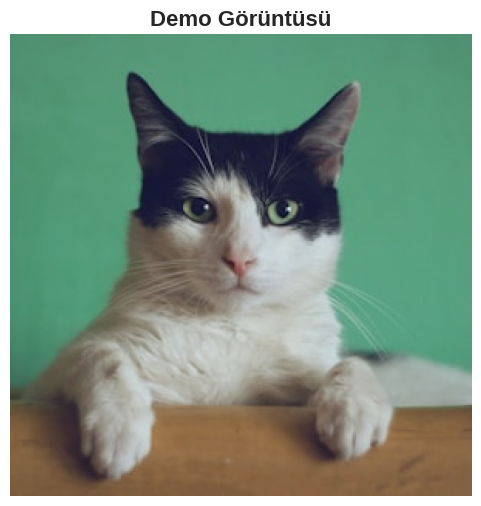

✅ Görüntü yüklendi! Shape: (299, 299, 3)


In [ ]:
# SEÇENEK 1: Sample Image (ÖNERİLEN)

# Birini seçin: 'cat', 'dog', 'bird', 'flower', 'car'
demo_image = load_sample_image('cat')

# Görüntüyü göster
plt.figure(figsize=(6, 6))
plt.imshow(demo_image)
plt.title('Demo Görüntüsü', fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

print(f"✅ Görüntü yüklendi! Shape: {demo_image.shape}")

## 3.2 Görüntüyü Ön İşleme

Convolution operasyonları için görüntüyü hazırlayalım.

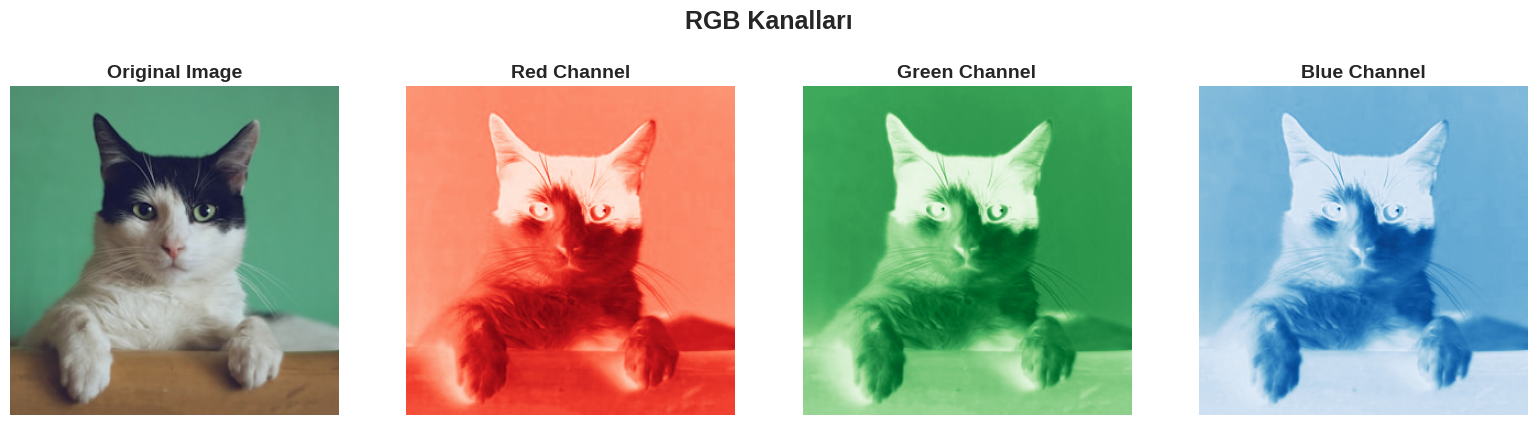

✅ Görüntü hazır!
📊 Normalized shape: (299, 299, 3)
📊 Batch shape: (1, 299, 299, 3)
📊 Value range: [0.000, 0.922]


In [ ]:
def preprocess_for_demo(image):
    """
    Demo için görüntü ön işleme
    """
    # [0, 255] → [0, 1]
    img_normalized = image.astype(np.float32) / 255.0

    # Batch dimension ekle: (H, W, C) → (1, H, W, C)
    img_batch = np.expand_dims(img_normalized, axis=0)

    return img_normalized, img_batch


# Görüntüyü hazırla
img_normalized, img_batch = preprocess_for_demo(demo_image)

# RGB kanallarını ayrı ayrı göster
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Orijinal
axes[0].imshow(img_normalized)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# R, G, B kanalları
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(3):
    axes[i+1].imshow(img_normalized[:,:,i], cmap=cmaps[i])
    axes[i+1].set_title(channel_names[i], fontsize=14, fontweight='bold')
    axes[i+1].axis('off')

plt.suptitle('RGB Kanalları', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print(f"✅ Görüntü hazır!")
print(f"📊 Normalized shape: {img_normalized.shape}")
print(f"📊 Batch shape: {img_batch.shape}")
print(f"📊 Value range: [{img_normalized.min():.3f}, {img_normalized.max():.3f}]")

## 3.3 Regular Convolution Demo

Regular convolution'ı gerçek görüntü üzerinde uygulayalım ve her adımı görselleştirelim.

🔴 Regular Convolution
Input shape:  (1, 299, 299, 3)  → (batch, height, width, channels)
Output shape: (1, 299, 299, 64)

Kernel shape: (3, 3, 3, 64)  → (kernel_h, kernel_w, in_ch, out_ch)

Total parameters: 1,792


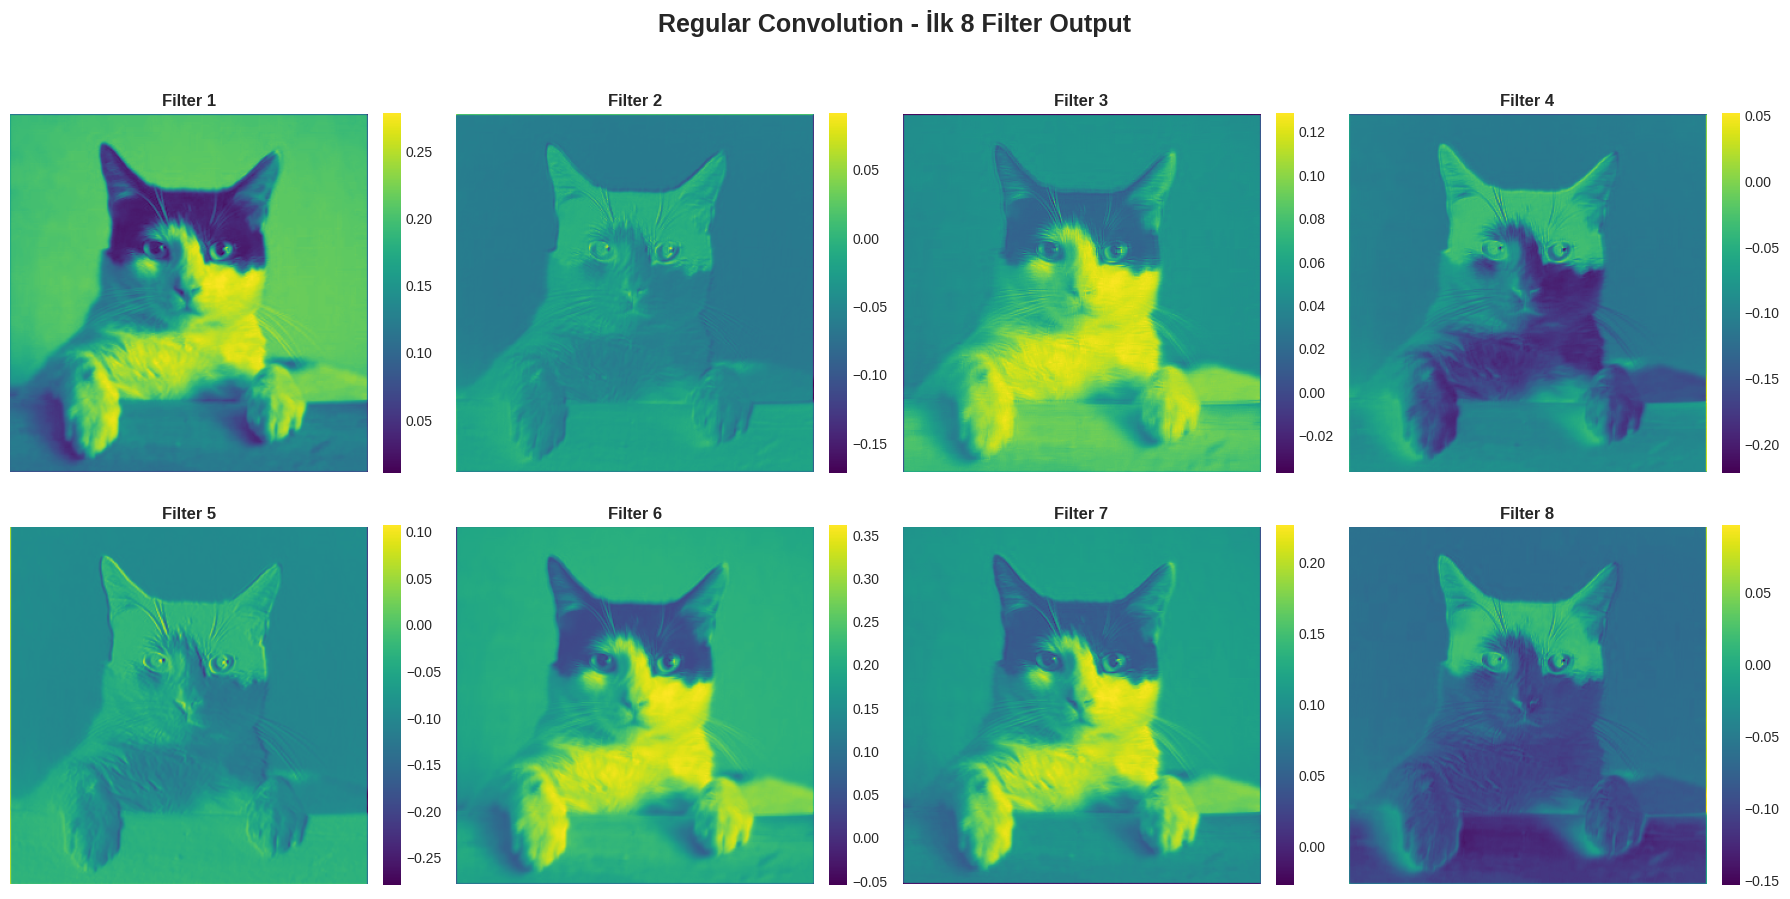


📊 Feature Map İstatistikleri:
Min value: -0.684
Max value: 0.466
Mean value: -0.002
Std deviation: 0.165


In [ ]:
# Regular Convolution Layer tanımla (TensorFlow)
regular_conv_layer = tf.keras.layers.Conv2D(
    filters=64,  # 64 output channel
    kernel_size=3,
    strides=1,
    padding='same',
    activation=None,  # Aktivasyon yok (raw output görmek için)
    name='regular_conv'
)

# Forward pass
regular_output = regular_conv_layer(img_batch)

print("🔴 Regular Convolution")
print("="*60)
print(f"Input shape:  {img_batch.shape}  → (batch, height, width, channels)")
print(f"Output shape: {regular_output.shape}")
print(f"\nKernel shape: {regular_conv_layer.kernel.shape}  → (kernel_h, kernel_w, in_ch, out_ch)")
print(f"\nTotal parameters: {regular_conv_layer.count_params():,}")

# Bazı filtreler için çıktıları göster
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
fig.suptitle('Regular Convolution - İlk 8 Filter Output', fontsize=18, fontweight='bold', y=1.02)

# İlk 8 filter output'unu göster
for i in range(8):
    ax = axes[i // 4, i % 4]
    feature_map = regular_output[0, :, :, i].numpy()

    im = ax.imshow(feature_map, cmap='viridis')
    ax.set_title(f'Filter {i+1}', fontsize=12, fontweight='bold')
    ax.axis('off')

    # Colorbar ekle
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Feature map istatistikleri
print("\n📊 Feature Map İstatistikleri:")
print(f"Min value: {regular_output.numpy().min():.3f}")
print(f"Max value: {regular_output.numpy().max():.3f}")
print(f"Mean value: {regular_output.numpy().mean():.3f}")
print(f"Std deviation: {regular_output.numpy().std():.3f}")

### 🔍 Kernel Görselleştirmesi

Regular convolution'ın öğrendiği kernel'lara bakalım.

Kernel shape: (3, 3, 3, 64)
(kernel_height, kernel_width, input_channels, output_channels)


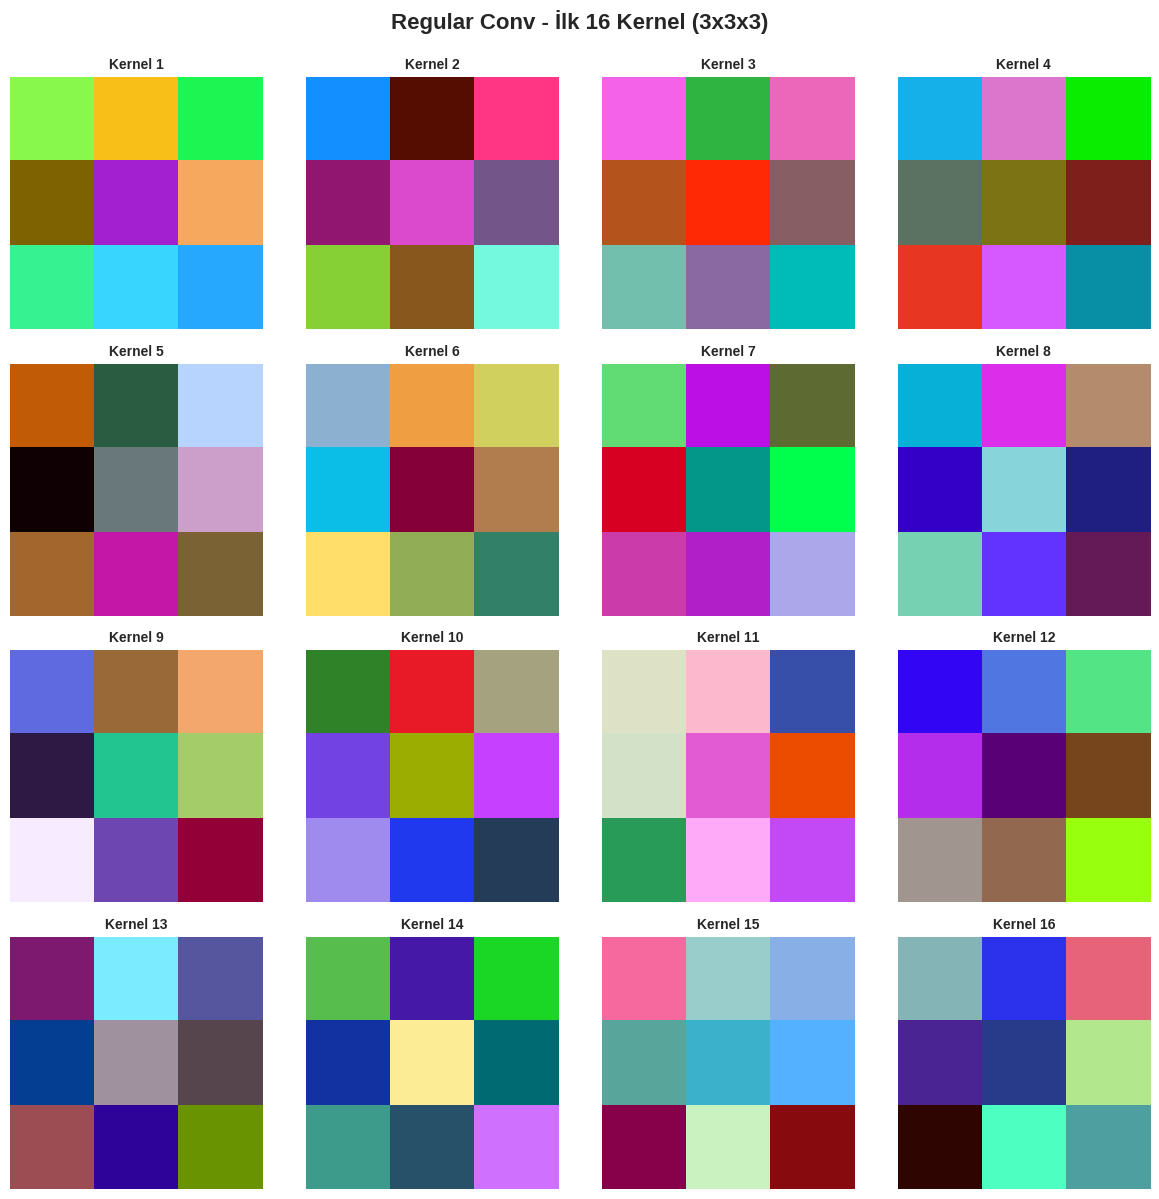


💡 Not: Her kernel 3x3x3 boyutunda (RGB için 3 channel)
Her output channel için bir kernel var (toplam 64 kernel)


In [ ]:
# Kernel'ları al
kernels = regular_conv_layer.kernel.numpy()  # Shape: (3, 3, 3, 64)

print(f"Kernel shape: {kernels.shape}")
print(f"(kernel_height, kernel_width, input_channels, output_channels)")

# İlk 16 kernel'ı görselleştir
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Regular Conv - İlk 16 Kernel (3x3x3)', fontsize=16, fontweight='bold', y=0.995)

for i in range(16):
    ax = axes[i // 4, i % 4]

    # Her kernel'ın 3 RGB channel'ını normalize et ve görselleştir
    kernel_rgb = kernels[:, :, :, i]  # (3, 3, 3)

    # Normalize et [0, 1] range'e
    k_min, k_max = kernel_rgb.min(), kernel_rgb.max()
    if k_max - k_min > 0:
        kernel_normalized = (kernel_rgb - k_min) / (k_max - k_min)
    else:
        kernel_normalized = kernel_rgb

    ax.imshow(kernel_normalized)
    ax.set_title(f'Kernel {i+1}', fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Not: Her kernel 3x3x3 boyutunda (RGB için 3 channel)")
print("Her output channel için bir kernel var (toplam 64 kernel)")

## 3.4 Depthwise Convolution Demo

Şimdi depthwise convolution'ı görelim. Her channel **bağımsız** olarak işlenir.

🔵 Depthwise Convolution
Input shape:  (1, 299, 299, 3)
Output shape: (1, 299, 299, 3)

Kernel shape: (3, 3, 3, 1)  → (k_h, k_w, in_ch, depth_mult)

Total parameters: 30

💡 Not: Output channel sayısı = Input channel sayısı (3)
Her channel bağımsız olarak işlendi!


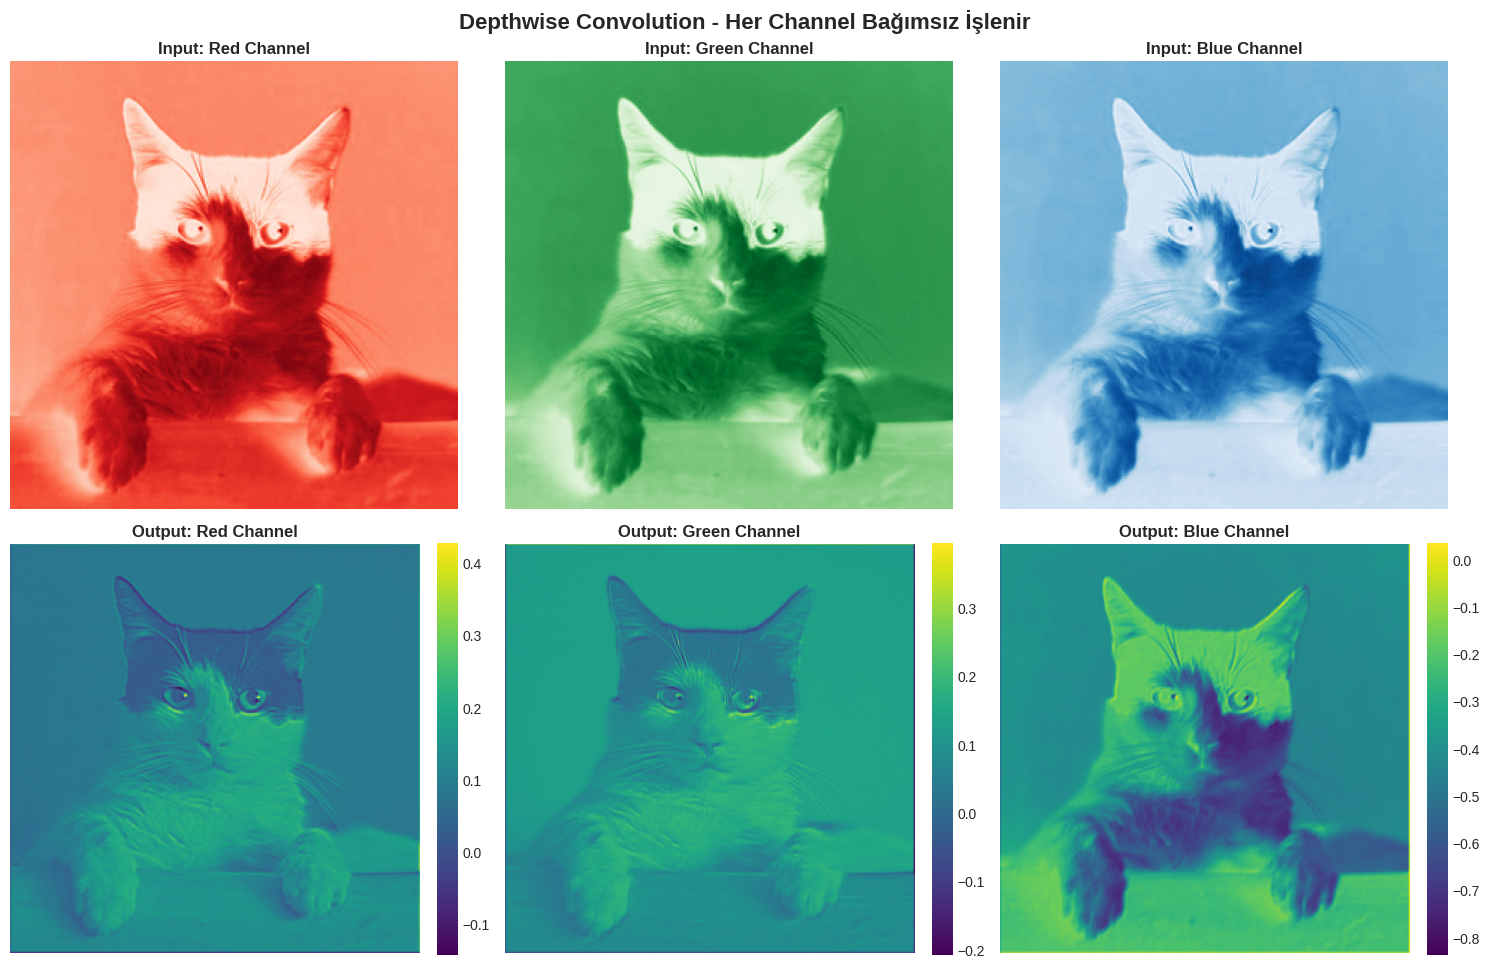

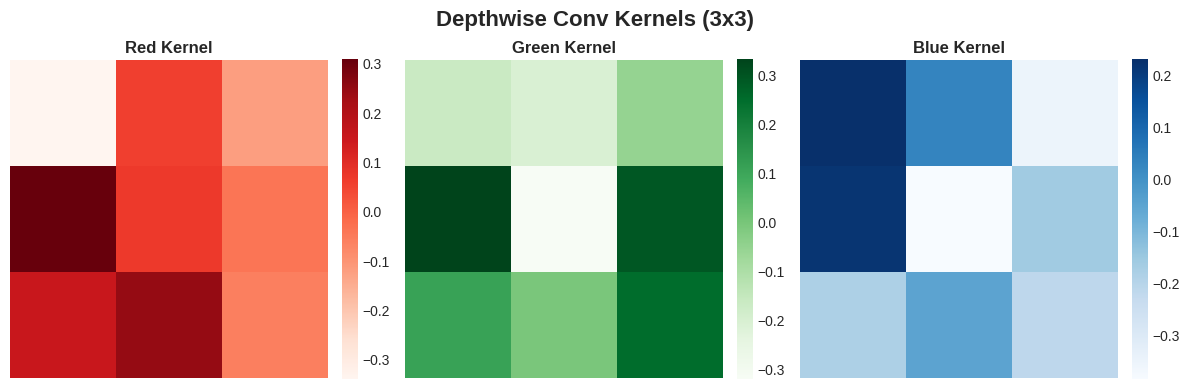


✅ Depthwise convolution: Sadece 30 parametre!
Regular convolution: 1,792 parametre
Fark: 59.7x daha az!


In [ ]:
# Depthwise Convolution Layer
depthwise_conv_layer = tf.keras.layers.DepthwiseConv2D(
    kernel_size=3,
    strides=1,
    padding='same',
    depth_multiplier=1,  # Her channel için 1 kernel
    activation=None,
    name='depthwise_conv'
)

# Forward pass
depthwise_output = depthwise_conv_layer(img_batch)

print("🔵 Depthwise Convolution")
print("="*60)
print(f"Input shape:  {img_batch.shape}")
print(f"Output shape: {depthwise_output.shape}")
print(f"\nKernel shape: {depthwise_conv_layer.trainable_weights[0].shape}  → (k_h, k_w, in_ch, depth_mult)")
print(f"\nTotal parameters: {depthwise_conv_layer.count_params():,}")
print(f"\n💡 Not: Output channel sayısı = Input channel sayısı (3)")
print(f"Her channel bağımsız olarak işlendi!")

# Her channel'ın output'unu göster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Üst satır: Input channels
channel_names = ['Red', 'Green', 'Blue']
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(3):
    # Input channel
    axes[0, i].imshow(img_normalized[:,:,i], cmap=cmaps[i])
    axes[0, i].set_title(f'Input: {channel_names[i]} Channel', fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

    # Output channel (depthwise conv sonucu)
    output_channel = depthwise_output[0, :, :, i].numpy()
    im = axes[1, i].imshow(output_channel, cmap='viridis')
    axes[1, i].set_title(f'Output: {channel_names[i]} Channel', fontsize=12, fontweight='bold')
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

fig.suptitle('Depthwise Convolution - Her Channel Bağımsız İşlenir',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Kernel'ları göster
kernels_depthwise = depthwise_conv_layer.trainable_weights[0].numpy()  # (3, 3, 3, 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Depthwise Conv Kernels (3x3)', fontsize=16, fontweight='bold')

for i in range(3):
    kernel = kernels_depthwise[:, :, i, 0]  # Her channel için bir 3x3 kernel
    im = axes[i].imshow(kernel, cmap=cmaps[i])
    axes[i].set_title(f'{channel_names[i]} Kernel', fontsize=12, fontweight='bold')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"\n✅ Depthwise convolution: Sadece {depthwise_conv_layer.count_params()} parametre!")
print(f"Regular convolution: {regular_conv_layer.count_params():,} parametre")
print(f"Fark: {regular_conv_layer.count_params() / depthwise_conv_layer.count_params():.1f}x daha az!")

## 3.5 Pointwise Convolution Demo

Pointwise convolution (1x1 conv) channel'ları mix eder.

🟢 Pointwise Convolution (1x1)
Input shape:  (1, 299, 299, 3)
Output shape: (1, 299, 299, 64)

Kernel shape: (1, 1, 3, 64)  → (1, 1, in_ch, out_ch)

Total parameters: 256

💡 Not: 1x1 kernel sadece channel'ları mix eder, spatial bilgi korunur!


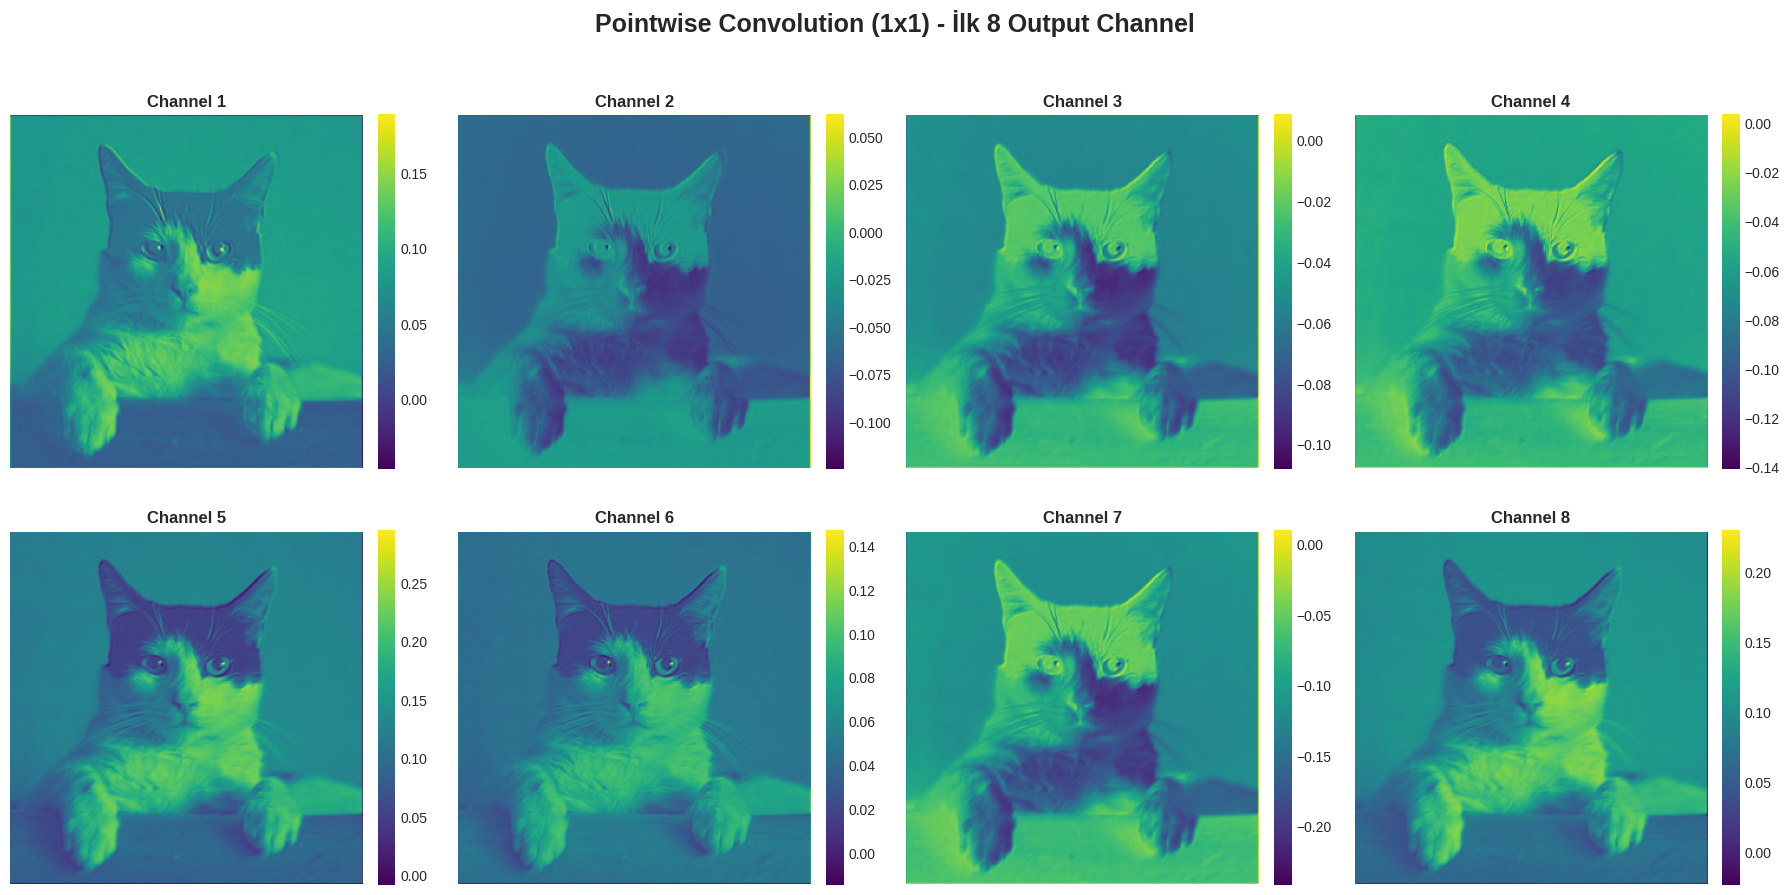

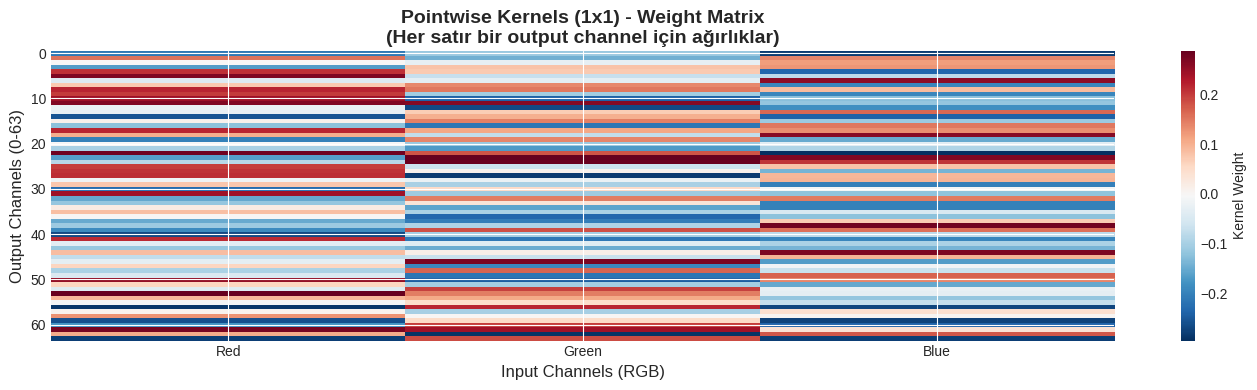


✅ Pointwise convolution: 256 parametre


In [ ]:
# Pointwise Convolution (1x1 Conv)
pointwise_conv_layer = tf.keras.layers.Conv2D(
    filters=64,  # 64 output channel
    kernel_size=1,  # 1x1 convolution
    strides=1,
    padding='same',
    activation=None,
    name='pointwise_conv'
)

# Depthwise output'u pointwise'a ver
pointwise_output = pointwise_conv_layer(depthwise_output)

print("🟢 Pointwise Convolution (1x1)")
print("="*60)
print(f"Input shape:  {depthwise_output.shape}")
print(f"Output shape: {pointwise_output.shape}")
print(f"\nKernel shape: {pointwise_conv_layer.kernel.shape}  → (1, 1, in_ch, out_ch)")
print(f"\nTotal parameters: {pointwise_conv_layer.count_params():,}")
print(f"\n💡 Not: 1x1 kernel sadece channel'ları mix eder, spatial bilgi korunur!")

# İlk 8 output channel'ı göster
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
fig.suptitle('Pointwise Convolution (1x1) - İlk 8 Output Channel',
             fontsize=18, fontweight='bold', y=1.02)

for i in range(8):
    ax = axes[i // 4, i % 4]
    feature_map = pointwise_output[0, :, :, i].numpy()

    im = ax.imshow(feature_map, cmap='viridis')
    ax.set_title(f'Channel {i+1}', fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Pointwise kernel'ları göster (1x1x3x64)
kernels_pointwise = pointwise_conv_layer.kernel.numpy()  # (1, 1, 3, 64)
kernels_pointwise_squeezed = kernels_pointwise.squeeze()  # (3, 64)

plt.figure(figsize=(14, 4))
plt.imshow(kernels_pointwise_squeezed.T, cmap='RdBu_r', aspect='auto')
plt.colorbar(label='Kernel Weight')
plt.title('Pointwise Kernels (1x1) - Weight Matrix\n(Her satır bir output channel için ağırlıklar)',
          fontsize=14, fontweight='bold')
plt.xlabel('Input Channels (RGB)', fontsize=12)
plt.ylabel('Output Channels (0-63)', fontsize=12)
plt.xticks([0, 1, 2], ['Red', 'Green', 'Blue'])
plt.tight_layout()
plt.show()

print(f"\n✅ Pointwise convolution: {pointwise_conv_layer.count_params():,} parametre")

## 3.6 Depthwise Separable Convolution (Tam Pipeline)

Şimdi **Depthwise + Pointwise** kombinasyonunu görelim ve Regular Conv ile karşılaştıralım.

In [ ]:
# Depthwise Separable Convolution Pipeline
print("🟠 Depthwise Separable Convolution (Depthwise + Pointwise)")
print("="*70)

# TensorFlow'da built-in SeparableConv2D var
separable_conv_layer = tf.keras.layers.SeparableConv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    depth_multiplier=1,
    activation=None,
    name='separable_conv'
)

# Forward pass
separable_output = separable_conv_layer(img_batch)

print(f"Input shape:  {img_batch.shape}")
print(f"Output shape: {separable_output.shape}")
print(f"\nDepthwise kernel: {separable_conv_layer.depthwise_kernel.shape}")
print(f"Pointwise kernel: {separable_conv_layer.pointwise_kernel.shape}")
print(f"\nTotal parameters: {separable_conv_layer.count_params():,}")

# Karşılaştırma tablosu
print("\n" + "="*70)
print("📊 PARAMETRE KARŞILAŞTIRMASI")
print("="*70)

regular_params = regular_conv_layer.count_params()
separable_params = separable_conv_layer.count_params()
reduction = (1 - separable_params / regular_params) * 100

print(f"\n🔴 Regular Convolution:")
print(f"   └─ Parametreler: {regular_params:,}")
print(f"\n🟠 Depthwise Separable Convolution:")
print(f"   ├─ Depthwise:  {depthwise_conv_layer.count_params():,} params")
print(f"   ├─ Pointwise:  {pointwise_conv_layer.count_params():,} params")
print(f"   └─ Toplam:     {separable_params:,} params")
print(f"\n💡 Parametre Azalması: {reduction:.1f}%")
print(f"💡 Sıkıştırma Oranı: 1:{regular_params/separable_params:.1f}")
print("="*70)

🟠 Depthwise Separable Convolution (Depthwise + Pointwise)
Input shape:  (1, 299, 299, 3)
Output shape: (1, 299, 299, 64)

Depthwise kernel: (3, 3, 3, 1)
Pointwise kernel: (1, 1, 3, 64)

Total parameters: 283

📊 PARAMETRE KARŞILAŞTIRMASI

🔴 Regular Convolution:
   └─ Parametreler: 1,792

🟠 Depthwise Separable Convolution:
   ├─ Depthwise:  30 params
   ├─ Pointwise:  256 params
   └─ Toplam:     283 params

💡 Parametre Azalması: 84.2%
💡 Sıkıştırma Oranı: 1:6.3


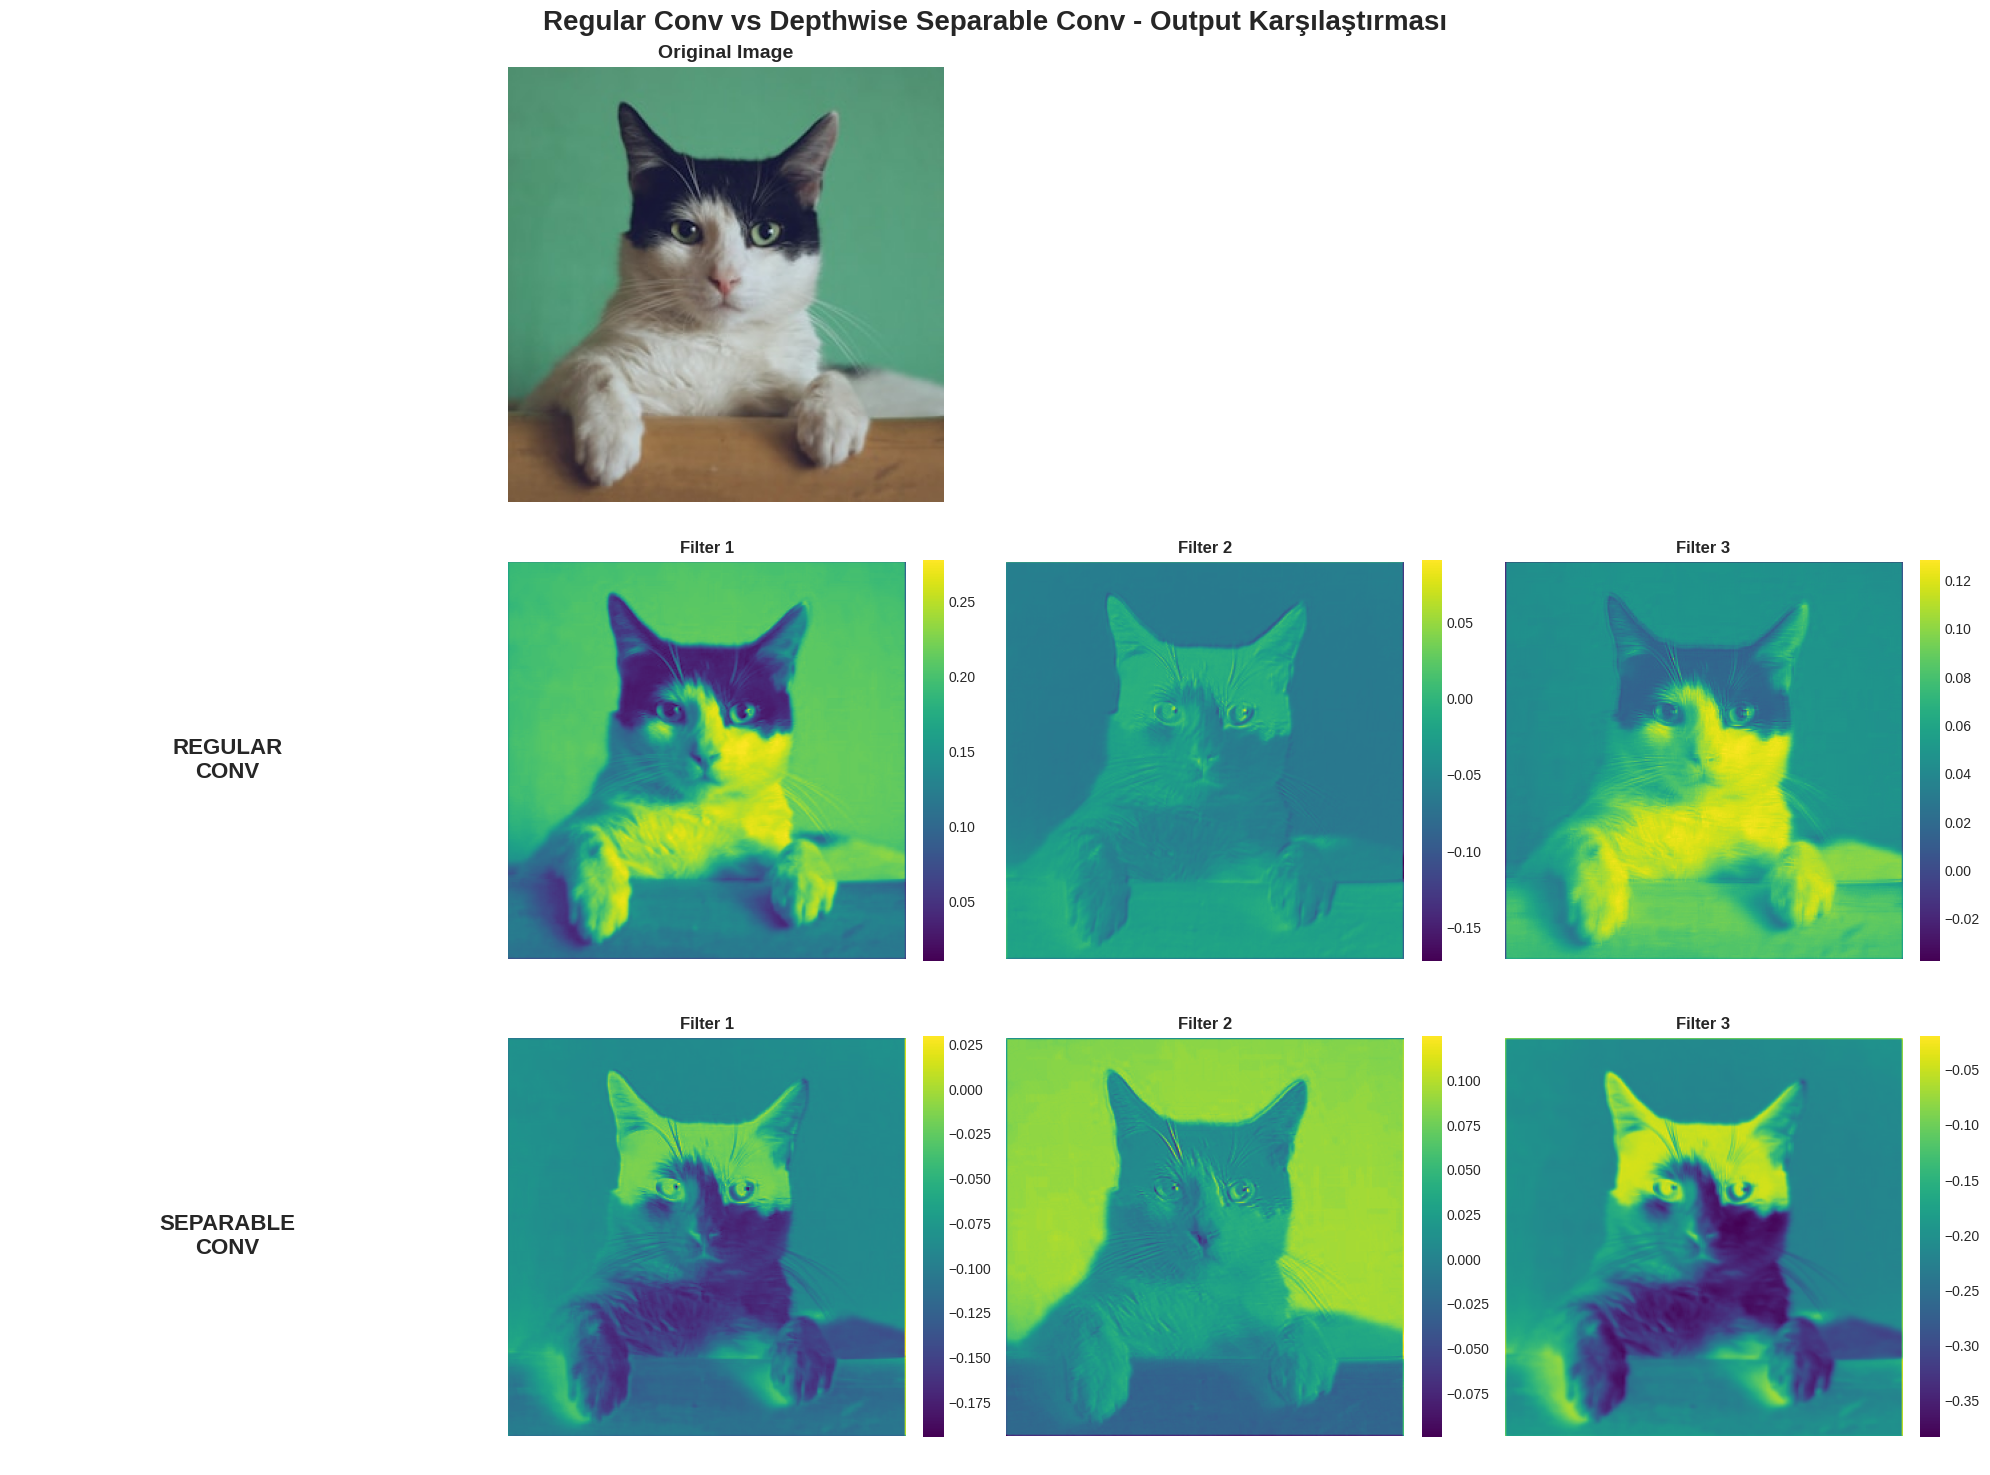


💡 Gözlem:
Her iki convolution türü de benzer feature maps üretiyor.
Ancak Separable Conv çok daha az parametre kullanıyor!


In [ ]:
# Görsel Karşılaştırma: Regular vs Separable
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Başlık
fig.suptitle('Regular Conv vs Depthwise Separable Conv - Output Karşılaştırması',
             fontsize=20, fontweight='bold', y=0.98)

# Orijinal görüntü (üst satır ortada)
axes[0, 1].imshow(img_normalized)
axes[0, 1].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Boş subplot'ları kapat
axes[0, 0].axis('off')
axes[0, 2].axis('off')
axes[0, 3].axis('off')

# İkinci satır: Regular Conv outputs
axes[1, 0].text(0.5, 0.5, 'REGULAR\nCONV',
                ha='center', va='center', fontsize=16, fontweight='bold',
                transform=axes[1, 0].transAxes)
axes[1, 0].axis('off')

for i in range(3):
    feature_map = regular_output[0, :, :, i].numpy()
    im = axes[1, i+1].imshow(feature_map, cmap='viridis')
    axes[1, i+1].set_title(f'Filter {i+1}', fontsize=12, fontweight='bold')
    axes[1, i+1].axis('off')
    plt.colorbar(im, ax=axes[1, i+1], fraction=0.046, pad=0.04)

# Üçüncü satır: Separable Conv outputs
axes[2, 0].text(0.5, 0.5, 'SEPARABLE\nCONV',
                ha='center', va='center', fontsize=16, fontweight='bold',
                transform=axes[2, 0].transAxes)
axes[2, 0].axis('off')

for i in range(3):
    feature_map = separable_output[0, :, :, i].numpy()
    im = axes[2, i+1].imshow(feature_map, cmap='viridis')
    axes[2, i+1].set_title(f'Filter {i+1}', fontsize=12, fontweight='bold')
    axes[2, i+1].axis('off')
    plt.colorbar(im, ax=axes[2, i+1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\n💡 Gözlem:")
print("Her iki convolution türü de benzer feature maps üretiyor.")
print("Ancak Separable Conv çok daha az parametre kullanıyor!")

---

## 🎯 Part 1 Özeti

### Ne Öğrendik?

1. ✅ **Regular Convolution:** Spatial ve channel correlations'ı birlikte öğrenir
2. ✅ **Depthwise Convolution:** Her channel bağımsız spatial features öğrenir
3. ✅ **Pointwise Convolution:** Sadece channel mixing yapar
4. ✅ **Depthwise Separable Conv:** İkisinin kombinasyonu, çok daha az parametre!

### Parametre Kazancı:

$$\frac{\text{Params}_{separable}}{\text{Params}_{regular}} = \frac{1}{C_{out}} + \frac{1}{k^2} \approx \frac{1}{8} \text{ veya daha az!}$$

### Sıradaki Part'ta:

- 🏗️ **Inception modüllerinin evrimi**
- 🎯 **Xception mimarisi detayları**
- 🔥 **Pre-trained model ile inference**
- 🎨 **Grad-CAM görselleştirmesi**

---

## 📝 Notlar:

Bu notebook **Part 1/3**. Devam etmek için **Part 2** dosyasını açın!

**Part 2:** `xception_part2_architecture_inference.ipynb`

---

### 📚 Referanslar:

- Chollet, F. (2017). Xception: Deep Learning with Depthwise Separable Convolutions. CVPR 2017.
- [TensorFlow Xception Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception)
- [Keras Applications - Xception](https://keras.io/api/applications/xception/)

---

**👨‍🎓 Hazırlayan:** Çağatay ÜRESİN  
**📅 Tarih:** 17 Aralık 2025  
**📧 GitHub:** [@cagatayuresin](https://github.com/cagatayuresin)